<a href="https://colab.research.google.com/github/Steve-YJ/Exp-Standalone-DeepLearning/blob/master/Code_Lec2_Pytorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning 홀로서기
## Reference: Standalone-DeepLearning

Date: 20.07.20.mon. pm10:30<br><br>
Notice<br>
본 노트북은 KAIST Standalone-DeepLearning을 공부하며 작성한 노트북입니다.
개인 학습 목적으로 Coding Skill 향상과 이론적인 이해를 바탕으로한 코드 작성을 지향합니다<br><br>

Review<br>
✅ 1. Last Time Review -20.07.21.tue-<br>
    모델 트레이닝 방법 이제 어느정도 익숙^^ 기쁘다!<br>
* 이번 시간 목표
    * Classification Problem 해결 with Pytorch
    * Linear Regression과 MLP를 둘 다 구현해본다
    * 모델이 생각하는 데이터의 분포를 시각화하여 MLP가 실제로 non-linear Decision-Boundary를 가질 수 있는지 살펴봅니다
    * 실습의 묘미!
    * Q. 모델이 생각하는 데이터의 분포를 시각화 한다? Non-linear Decision-Boundary를 어떻게 확인할 것인가?


## 1. Data Generation(Preparation)
* 이번 실습에서도 마찬가지로 실습에서 사용할 데이터를 만들어봅니다
* x는 2차원, y는 1차원인 상황입니다
* x는 continuous space에 존재하며 y는 class이기 때문에 discrete space에 분포합니다
* 이번시간에는 방사형 데이터 분포를 가상으로 만든 후 두 모델들이 비선형 decision-boundary를 형성할 수 있는지 테스트해보도록 하겠습니다
* 방사형 데이터 분포라...!(축구 게임에서 많이 사용하는 육각 스텟!)


Data Set
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

Text(0.5, 1.0, 'Test Set Distribution')

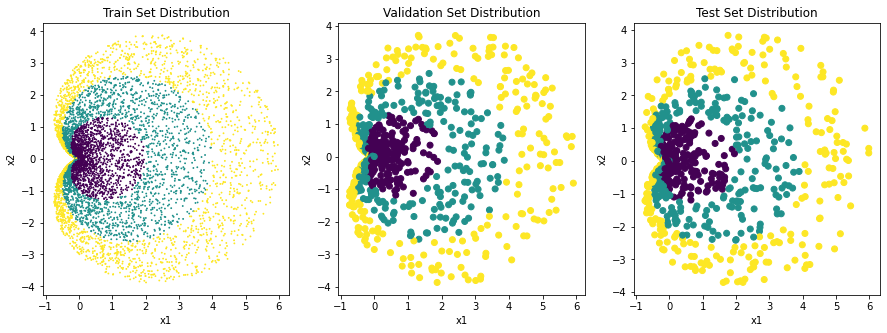

In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# ======= Generating Dataset ======= #
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# print(x1.shape, x2.shape, y.shape)

# ======= Split Dataset into Train, Validation, Test ======= #
train_X, train_y = X[:8000], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ======= Visualizae Each Dataset ======= #
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')


##2. Hypothesis Define (Model Define)
* Logistic Regression Model을 파이토치로 구현하는 방법
    * Regression 문제를 풀 때와 같이 nn.Linear 모듈과 non-linear activation function만 추가해주면 된다
* Module 내에서 Softmax함수를 사용할 필요가 없다(강조!) 왜?!
    * softmax함수가 뒤에 나오는 파이썬 내장 Cross-Entropy Loss함수에 들어가 있기 떄문이다
<br><br>


Multi-Label Logistic Model
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$

MLP Model$$Let \ relu(X) = \ max(X, 0)$$

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$
$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$
$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$

In [24]:
# pytorch로 구현을 해봅니다. 

import torch
import torch.nn as nn

class LinearModel(nn.Module):  # nn.Module을 상속하는 class 생성
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)

    def forward(self, x):  # 다른 함수는 안됩니다. 무조건 forward()
        x = self.linear(x)
        return x

# 이번에는 MLPModel을 생성합니다.
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200, bias=True)
        self.linear2 = nn.Linear(in_features=200, out_features=3, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

## 3. Cost Function Define (Loss Function Define)

* Multi-Label Problem일 때의 Loss Function을 작성해봅니다
* Pytorch의 nn package안에는 다양한 Loss Function이 이미 구현되어 있습니다


input은 $ N \times Num Class $ 차원을 가지면 되며 float 형태여야 하고,
target은 $ N $ 차원을 가지고 각 엘리먼트는 $ i $ 번째 클래스를 나타내는 int형이면 되는군요.

CrossEntropy Documentation : https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [5]:
cls_loss = nn.CrossEntropyLoss()

'''
# Cross Entropy를 테스트해봅니다
test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))
'''

'\n# Cross Entropy를 테스트해봅니다\ntest_pred_y = torch.Tensor([[2,0.1],[0,1]])\ntest_true_y1 = torch.Tensor([1,0]).long()\ntest_true_y2 = torch.Tensor([0,1]).long()\n\nprint(cls_loss(test_pred_y, test_true_y1))\nprint(cls_loss(test_pred_y, test_true_y2))\n'

## 4. Train & Evaluation
* 모델과 Loss Function을 정의했으니 이제 학습을 시켜보겠습니다
* 지난 시간에는 parameter의 업데이트를 위해 직접 loss값을 parameter에 따라 편미분해 gradient를 구하고 w를 업데이트 했습니다
* pytorch에서는 <code>loss.backward()</code>라는 기능을 통해 loss의 편미분 값을 자동으로 구할 수 있습니다
* 이후 optimizer.step()함수를 사용하면 각 파라미터의 gradient를 바탕으로 parameter값을 조금씩 업데이트해줍니다

<br>

* 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게 됩니다. 
* 그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다.
* 이번에는 Classification Task에서 기본적으로 사용하는 Accuracy를 Metric으로 활용해보겠습니다.
* accuracy를 계산하는 함수가 이미 sklearn.metrics에 구현되어 있으니 불러와 사용하도록 합시다.
accuracy_score Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

* <code>PyTorch.detach()</code>
    * detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable. The wrapper with torch
    * detach() wrapper를 호출하여 연산 기록으로부터 분리(detach)하여 이후의 연산들이 computational graph에 의해 추적되는 것을 방지할 수 있다

1203 parameters


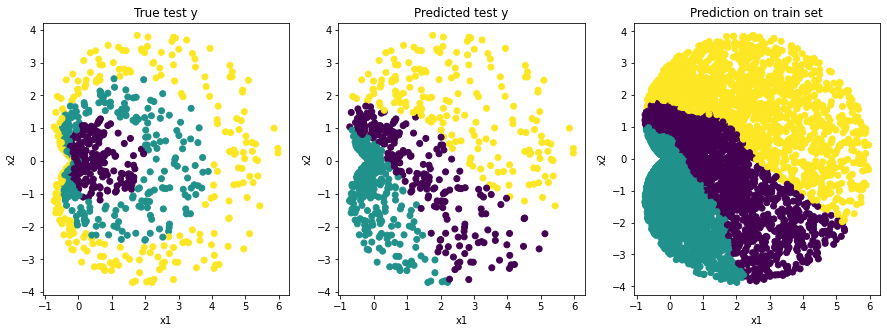

Epoch:  0 Accuracy:  38.6 %


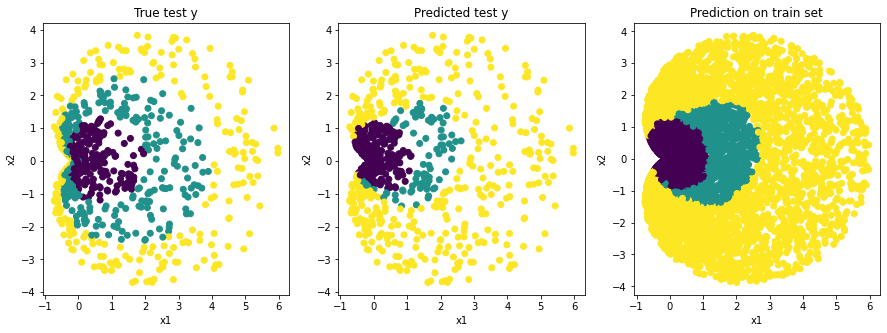

Epoch:  200 Accuracy:  56.10000000000001 %


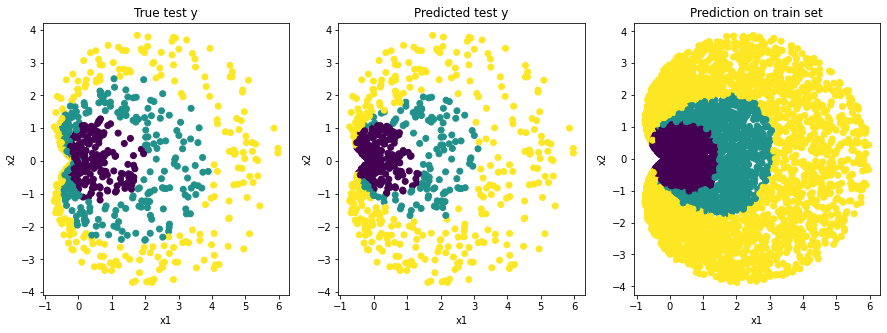

Epoch:  400 Accuracy:  63.0 %


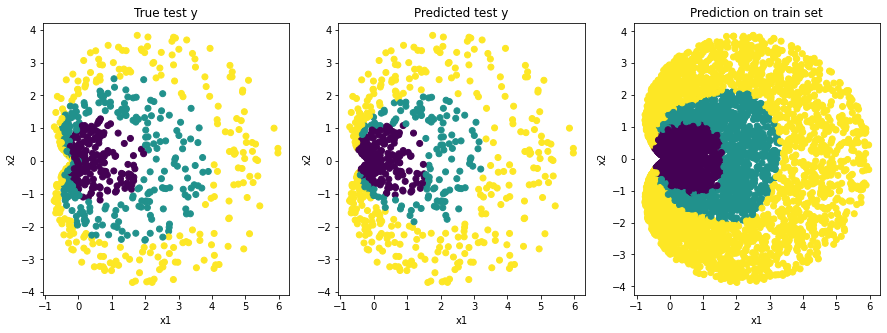

Epoch:  600 Accuracy:  66.5 %


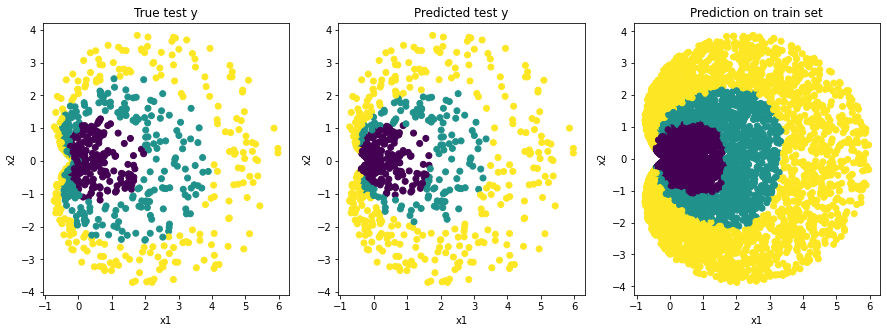

Epoch:  800 Accuracy:  68.4 %


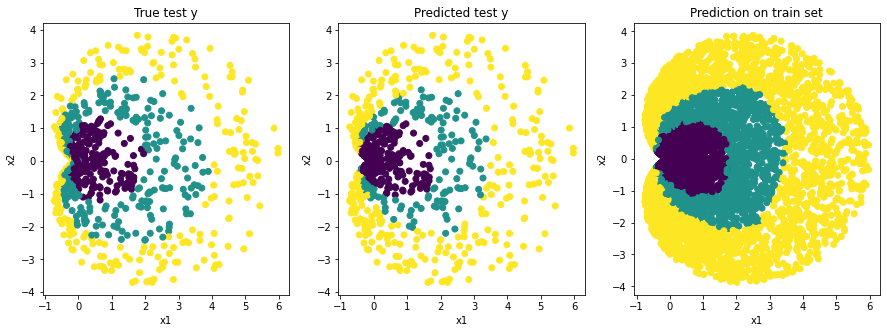

Epoch:  1000 Accuracy:  70.7 %


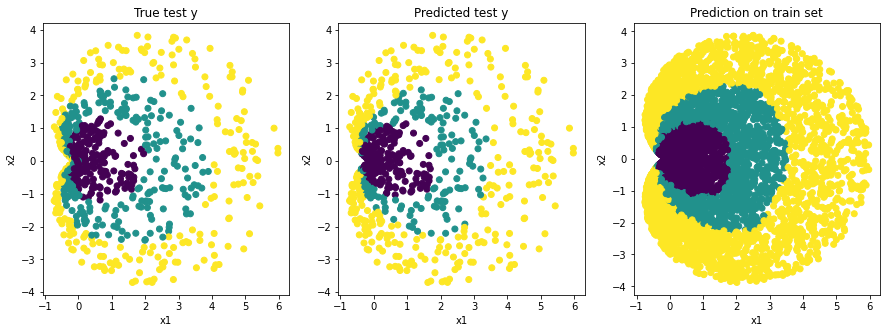

Epoch:  1200 Accuracy:  71.6 %


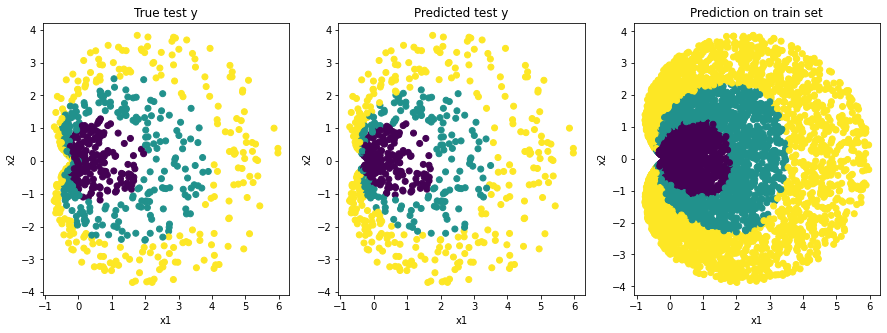

Epoch:  1400 Accuracy:  72.5 %


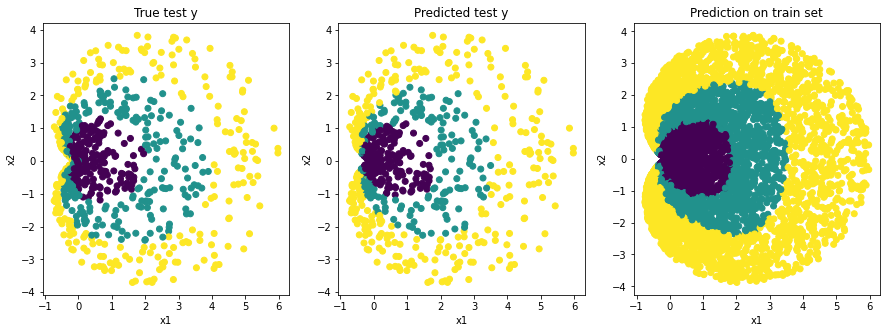

Epoch:  1600 Accuracy:  72.7 %


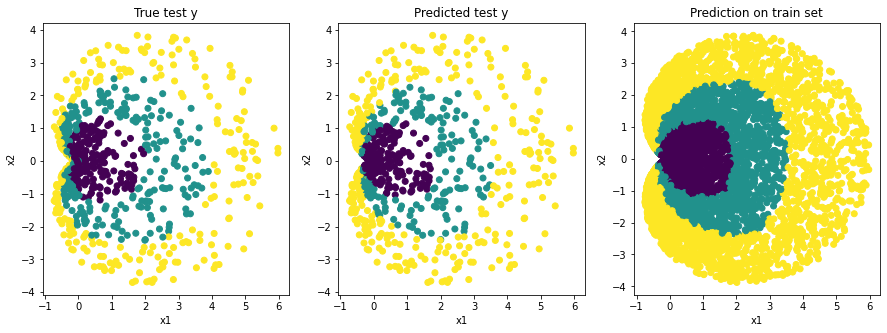

Epoch:  1800 Accuracy:  73.5 %


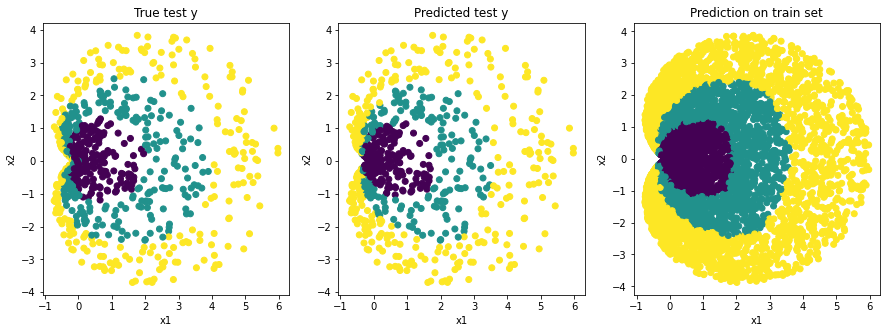

Epoch:  2000 Accuracy:  73.8 %


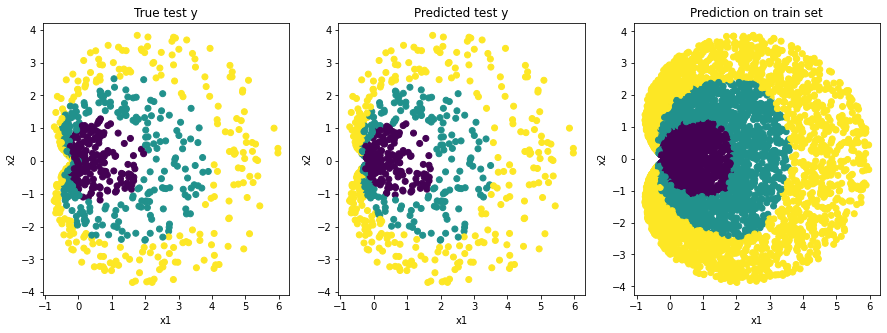

Epoch:  2200 Accuracy:  74.1 %


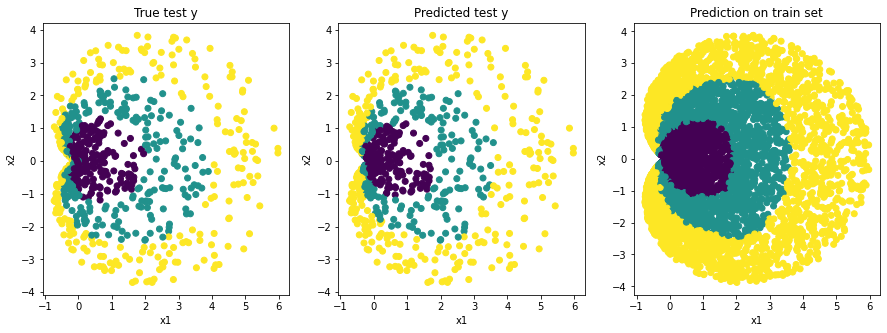

Epoch:  2400 Accuracy:  74.8 %


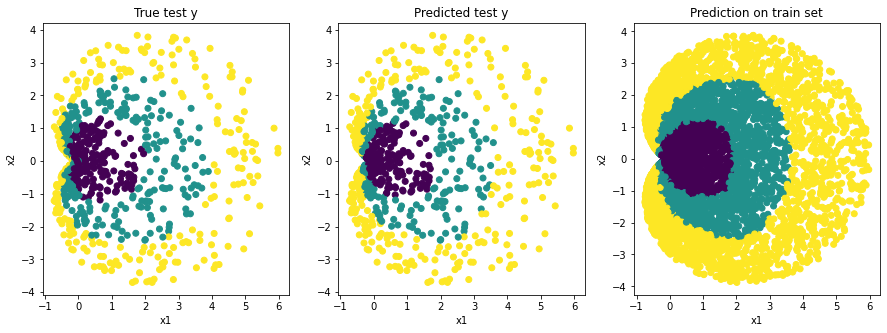

Epoch:  2600 Accuracy:  75.0 %


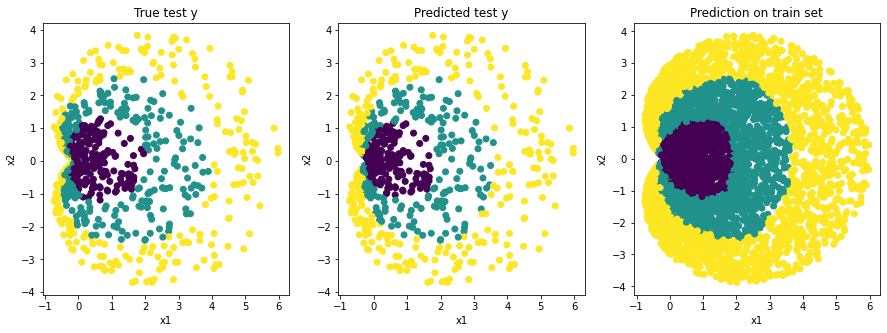

Epoch:  2800 Accuracy:  75.2 %


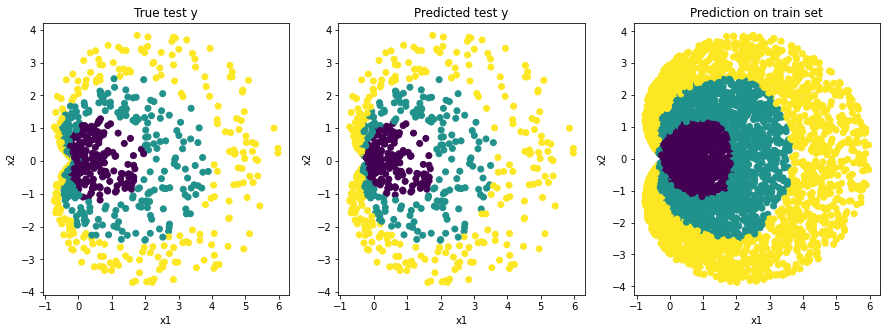

Epoch:  3000 Accuracy:  75.5 %


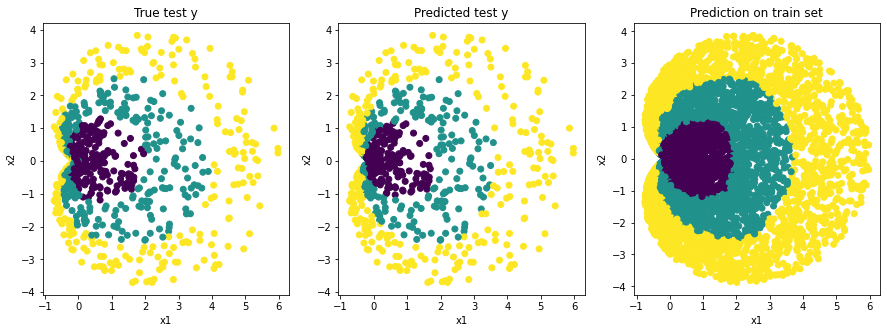

Epoch:  3200 Accuracy:  75.7 %


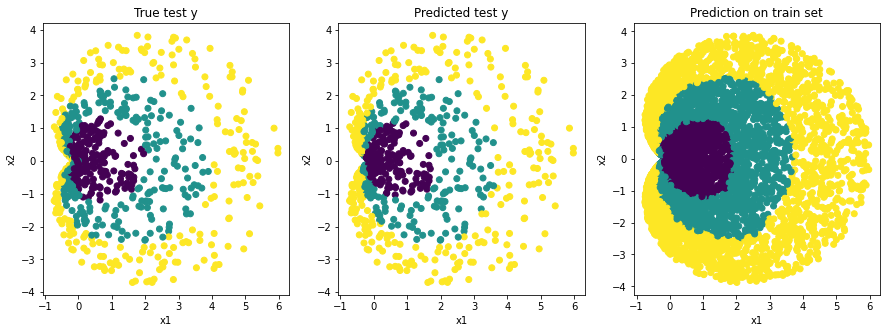

Epoch:  3400 Accuracy:  75.7 %


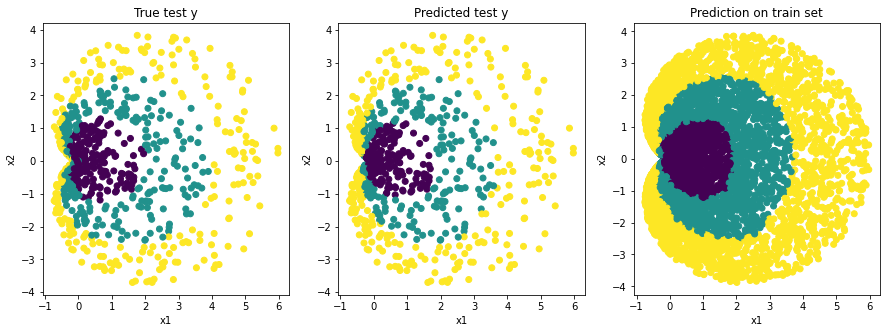

Epoch:  3600 Accuracy:  75.9 %


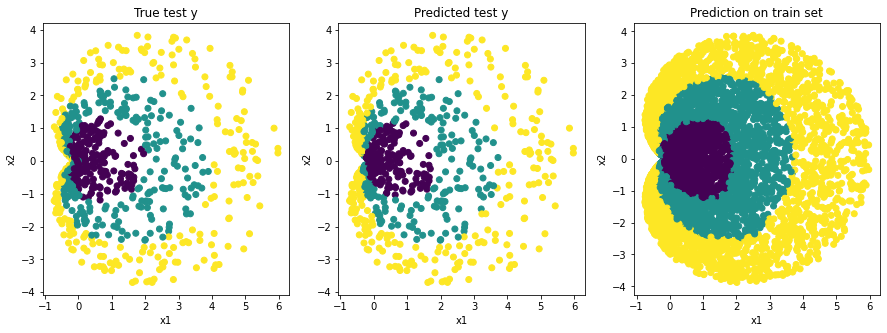

Epoch:  3800 Accuracy:  76.1 %


In [25]:
import torch.optim as optim
from sklearn.metrics import accuracy_score  # sklearn에서 accuracy를 계산하는 함수를 불러온다

model = MLPModel()  # Model 생성
# 모델내 학습 파라미터 수 counting
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 모델 내 학습을 담당할 파라미터 수를 카운팅하는 코드

# ======= Construct Optimizer ======= #
lr = 0.005  # Learning rate 설정
            # 학습할 떄 손이 조금 가는 부분이 바로 이 learning_rate입니다
optimizer = optim.SGD(model.parameters(), lr=lr)  # Optimizer를 생성

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 지정할 리스트 생성
list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 4000  # (전체 training dataset에 대한) 학습 횟수(epoch)을 지정해줍니다
for i in range(epoch):
    # ======= Train ======= #
    model.train()  # model을 train mode로 세팅
    model.zero_grad()  # 잔여 gradient 초기화

    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    # print('각 인풋과 아웃풋 shape 체크', input_x.shape, true_y.shape, pred_y.shape)
    # break

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()   # backward()를 통해 loss function에 대한 gradient를 구해줍니다
    optimizer.step()  # step()을 통해 gradient를 바탕으로 parameter를 업데이트 해줍니다
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())

    # ======= Validation ======= #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
## 여기까지가 Train, Validation.
## 4000 Epoch중 200마다 Evaluation을 수행한다.
## 200 Epoch마다 Test Dataset에 대해 성능 평가를 수행


    # ======= Evaluation ======= #
    if i % 200 == 0:  # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.

        # ======= Calculate Accuracy ======= #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)  # Training시 한 번도 사용하지 않았던 Test Set에 대해 학습 수행
        true_y = torch.Tensor(test_y)
        # pred_y = model(input_x).detach().numpy()
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y)
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15, 5))

        # ======= True Y Scattering ======= #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c = test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() # 예측 값(클래스별 확률)에서 가장 높은 값의 인덱스 값만 뽑아낸다
                                                               # 즉, 예측한 클래스 값이되고 이를 numpy()로 변환!
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

##5. Report Experiment

학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

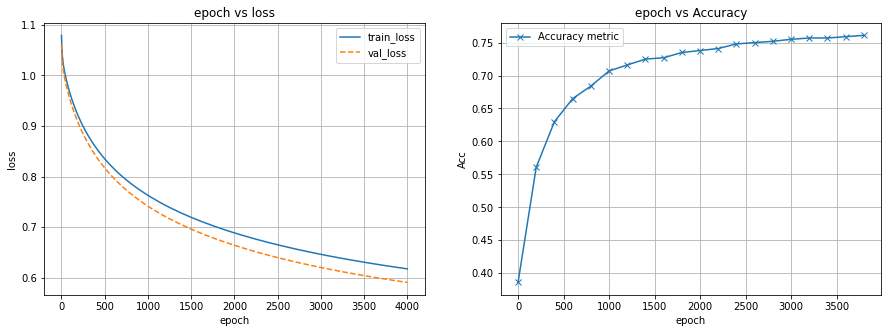

In [26]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

In [9]:
# PyTorch
# Reference: https://curioso365.tistory.com/48

t = torch.FloatTensor([[1, 2], [3, 4]])
print(t)

print(t.mean())
print(t.mean(dim=0))
print(t.mean(dim=1))

tensor([[1., 2.],
        [3., 4.]])
tensor(2.5000)
tensor([2., 3.])
tensor([1.5000, 3.5000])


In [14]:
print(t.sum())
print(t.sum(dim=0))
print(t.sum(dim=1))
print(t.sum(dim=-1))

tensor(10.)
tensor([4., 6.])
tensor([3., 7.])
tensor([3., 7.])


최대(Max, ArgMax)<br>
* t.max(): 전체 텐서 데이터 중 최대 값만 인출
* t.max(dim=0): 특정 차원단위 최대값(max)과 최대값을 갖는 인덱스 인출
* 이 때 차원을 지정하면 두 개의 데이터를 뽑을 수 있다
    * t.max(dim=0)[0]은 최대값(mxa)를 나타내고
    * t.max(dim=0)[1]은 최대값을 갖는 데이터의 인텍스를 나타낸다

In [20]:
# Example

t = torch.FloatTensor([[1, 2], [3, 4]])

print(t)
print(t.max(dim=0))
print('Max:', t.max(dim=0)[0])
print('Argmax:', t.max(dim=0)[1])

tensor([[1., 2.],
        [3., 4.]])
torch.return_types.max(
values=tensor([3., 4.]),
indices=tensor([1, 1]))
Max: tensor([3., 4.])
Argmax: tensor([1, 1])
